## Setup

<font color='red'>**Warning**: if you work on Colab, upload the data zip on Google Drive in order to not have to upload it on your environment every time. It's also much faster to upload files on Google Drive than on Colab.</font>

In [149]:
#from google.colab import drive
#drive.mount('/content/drive')

In [150]:
# Make sure to change path if you put the zip elsewhere
#!unzip chest_xray.zip

## Create dataset from directory

In [151]:
import tensorflow as tf
from pathlib import Path

IMG_WIDTH = IMG_HEIGHT = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/train'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/val'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/test'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


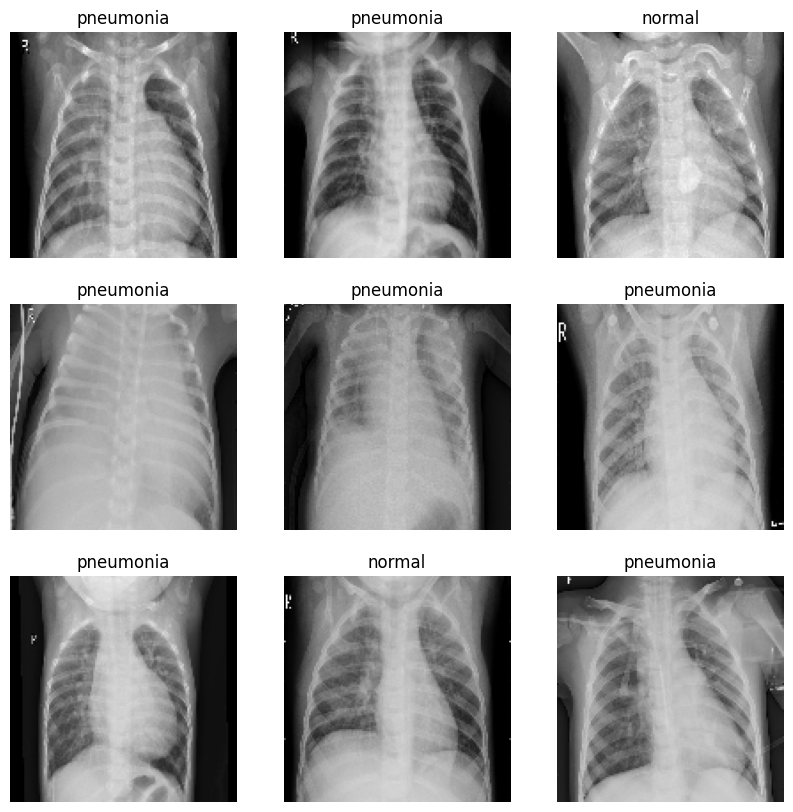

In [152]:
import matplotlib.pyplot as plt

# Extract a batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'{train_ds.class_names[int(labels[i])]}')
        plt.axis('off')

    plt.show()

## Compute class weights

In [153]:
import numpy as np

# Initialize class counts
class_counts = np.zeros(len(train_ds.class_names), dtype=np.int64)

# Iterate over the dataset to count samples in each class
for images, labels in train_ds:
    flattened_labels = tf.cast(labels, dtype=tf.int64)  # Cast labels to int64
    flattened_labels = tf.reshape(flattened_labels, [-1])  # Flatten the labels
    class_counts += np.bincount(flattened_labels.numpy(), minlength=len(train_ds.class_names))

# Compute total number of samples
total_samples = np.sum(class_counts)

# Compute class weights
num_classes = len(train_ds.class_names)
class_weights = {i: total_samples / (num_classes * count) for i, count in enumerate(class_counts)}

In [154]:
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

## Create CNN model

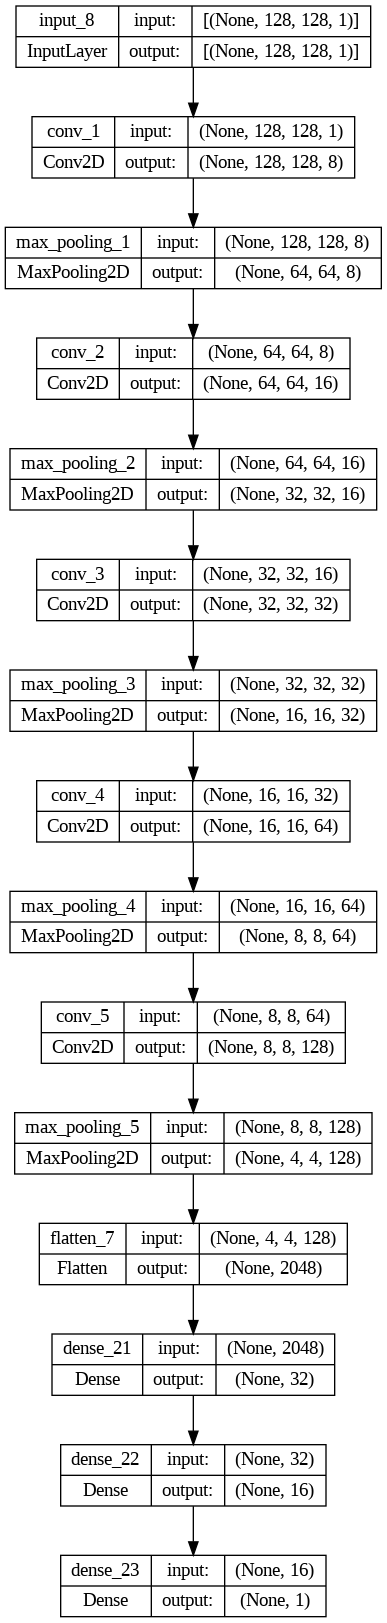

In [155]:
from tensorflow.keras import (
    layers,
    activations,
    Model,
    optimizers,
    losses
)

# Define CNN model
input = layers.Input((IMG_HEIGHT, IMG_WIDTH, 1))

# TODO: Complete this in order to have the same architecture
# as the one represented in the cell above
# note: use convolutions with relu and kernel size of 3.


# First convolution and max-pooling
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input)
x = layers.MaxPooling2D((2, 2))(x)

# Second convolution and max-pooling
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Third convolution and max-pooling
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Fourth convolution and max-pooling
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Fifth convolution and max-pooling
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Flattening the output to feed into dense layers
x = layers.Flatten()(x)

# Dense layers
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)
cnn_output = layers.Dense(1, activation='sigmoid')(x)

# Display the model summary to check if it matches the desired architecture

cnn = Model(inputs=input, outputs=cnn_output)

# Compile CNN model
cnn.compile(optimizer=optimizers.Adam(0.01), loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

cnn.summary()

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 128, 128, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 64, 64, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,353 (642.00 KB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 0 (0.00 B)

In [156]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(cnn, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [157]:
history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights
)

Epoch 1/50


82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - accuracy: 0.5116 - loss: 4.8701 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - accuracy: 0.3223 - loss: 0.6845 - val_accuracy: 0.5000 - val_loss: 0.6959
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - accuracy: 0.5186 - loss: 0.6917 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 202ms/step - accuracy: 0.4233 - loss: 0.6848 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 252ms/step - accuracy: 0.3708 - loss: 0.6850 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 224ms/step - accuracy: 0.3406 - loss: 0.6843 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 195ms/step - accuracy: 0.3430 - loss: 0.6842 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 18s 212ms/step - accuracy: 0.3305 - loss: 0.6842 - val_accuracy: 0.500

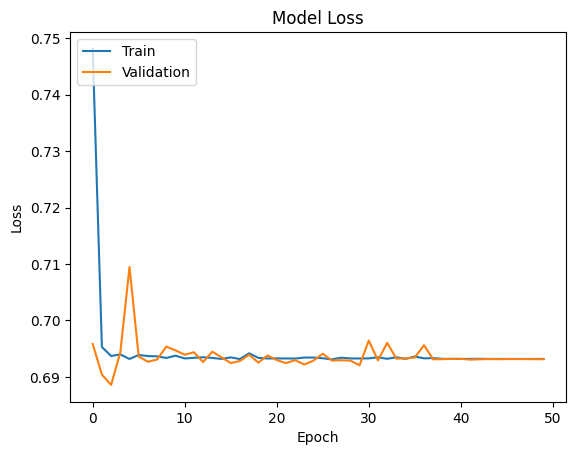

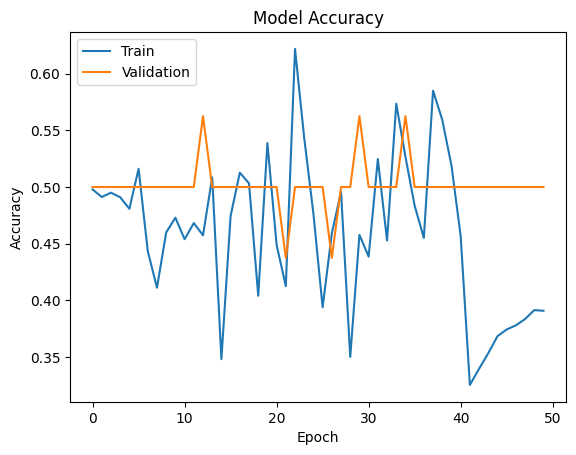

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


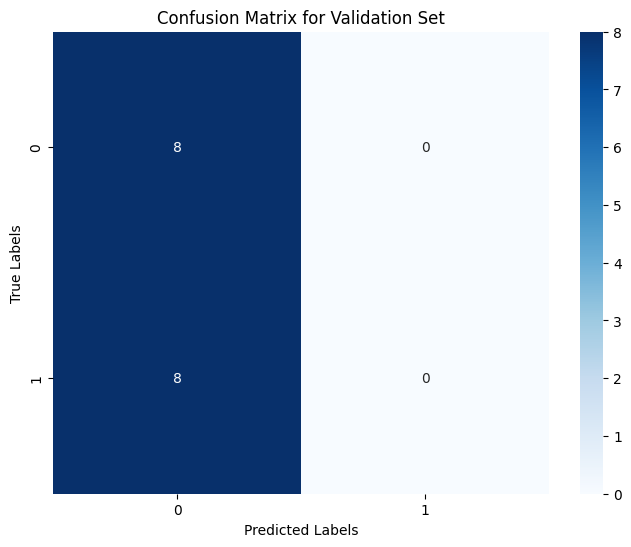

Accuracy: 0.50
Precision: 0.00
Recall: 0.00
F1 Score: 0.00


C:\Users\camko\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

val_images = []
val_labels = []

for img, label in val_ds:
  val_images.append(img)
  val_labels.append(label)

val_images = np.vstack(val_images)
val_labels = np.vstack(val_labels).squeeze().astype(int)

# TODO: create confusion matrix and compute metrics here
# and do the same for test set

val_predictions = cnn.predict(val_images)
val_predictions = np.round(val_predictions).astype(int)

cm = confusion_matrix(val_labels, val_predictions)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Validation Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Metrics calculation
accuracy = accuracy_score(val_labels, val_predictions)
precision = precision_score(val_labels, val_predictions)
recall = recall_score(val_labels, val_predictions)
f1 = f1_score(val_labels, val_predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


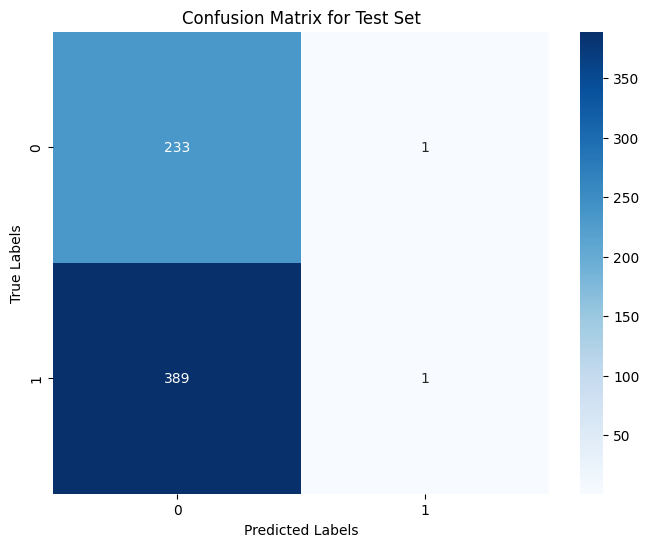

Test Accuracy: 0.38
Test Precision: 0.50
Test Recall: 0.00
Test F1 Score: 0.01


In [ ]:
test_images = []
test_labels = []

for img, label in test_ds:
    test_images.append(img)
    test_labels.append(label)

test_images = np.vstack(test_images)
test_labels = np.vstack(test_labels).squeeze().astype(int)

# Predict test set
test_predictions = cnn.predict(test_images)
test_predictions = np.round(test_predictions).astype(int)

# Compute the confusion matrix
test_cm = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Test Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Calculate metrics for the test set
test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions)

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1 Score: {test_f1:.2f}")
